In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
import hydra
import omegaconf
from omegaconf import DictConfig, OmegaConf
import os

import sklearn
from sklearn.datasets import make_moons
from sfm.distributions import get_source_distribution



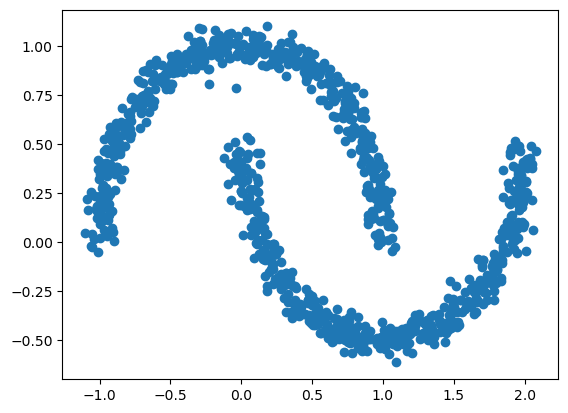

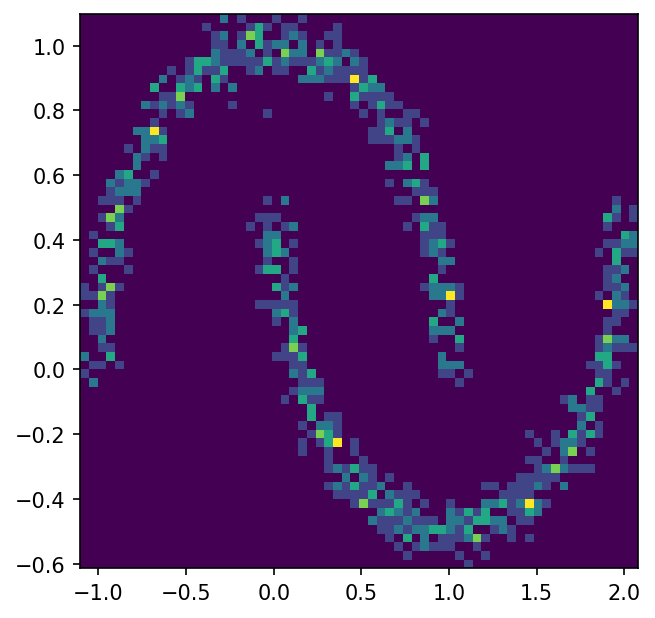

In [2]:
n_samples = 1000
datanoise = 0.05
data, _ = make_moons(n_samples, noise=datanoise)
data = torch.from_numpy(data).float()

plt.scatter(data[:, 0], data[:, 1])
plt.show()

if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*data.T, bins=64)
plt.show()

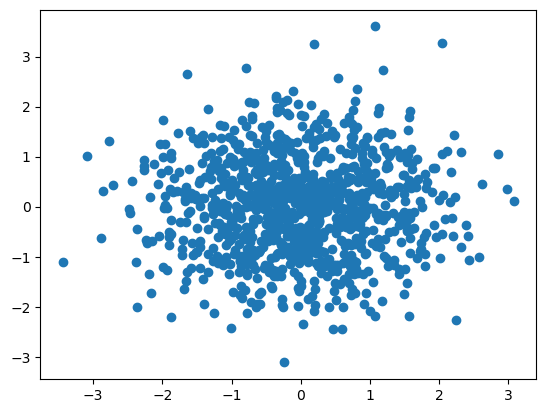

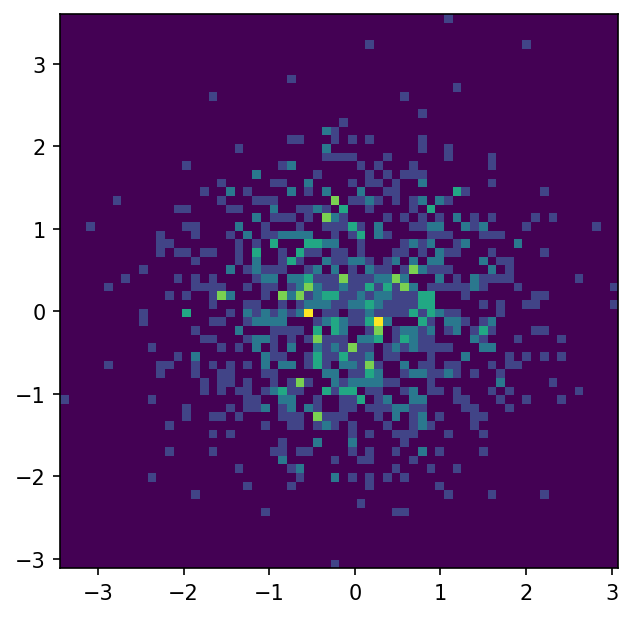

In [3]:

dist = get_source_distribution("normal")
samples = dist.sample(1000)

plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

if isinstance(samples, torch.Tensor):
    samples = samples.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*samples.T, bins=64)
plt.show()


In [4]:
def plot_dist(n_samples=1000, **kwargs):
    dist = get_source_distribution(**kwargs)
    samples = dist.sample(n_samples)

    # plt.scatter(samples[:, 0], samples[:, 1])
    # plt.show()

    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()
    plt.figure(figsize=(4.8, 4.8), dpi=150)
    plt.hist2d(*samples.T, bins=64)
    plt.show()

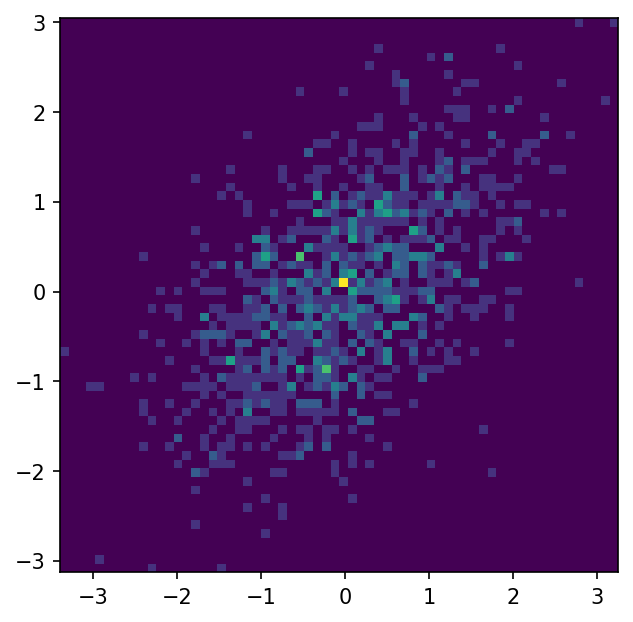

In [5]:
plot_dist(
    n_samples=1000,
    **{"type": "gaussian", "mu": torch.tensor([0.0, 0.0]), "Sigma": torch.tensor([[1.0, 0.5], [0.5, 1.0]])},
)


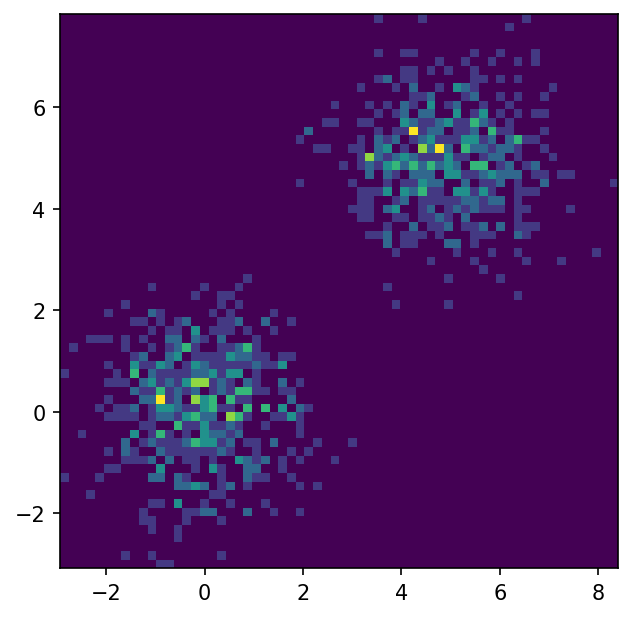

In [6]:
plot_dist(
    n_samples=1000,
    **{
        "type": "mog",
        "mus": torch.tensor([[0.0, 0.0], [5.0, 5.0]]),
        "sigmas": torch.tensor([[1.0, 1.0], [1.0, 1.0]]),
        "pis": torch.tensor([0.5, 0.5]),
    },
)

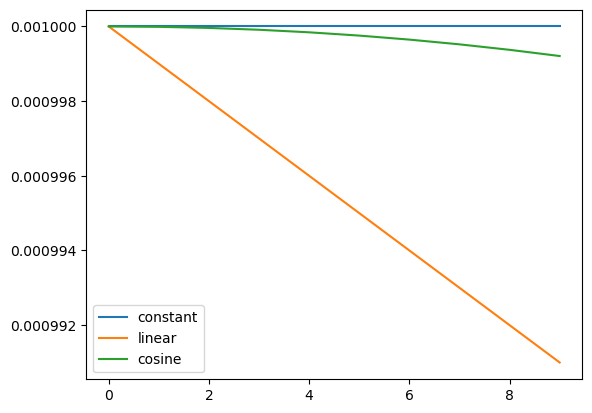

In [7]:
# plot learning rate schedule
from sfm.trainer import get_lr_schedule
from sfm.flowmodel import ContNormFlow, MLPwithTimeEmbedding

model = MLPwithTimeEmbedding()
model = ContNormFlow(model, source={"type": "gaussian", "mu": torch.tensor([0.0, 0.0]), "Sigma": torch.tensor([[1.0, 0.5], [0.5, 1.0]])})

schedules = ["constant", "linear", "cosine"]
for schedule in schedules:
    cfg = DictConfig({
        "optim": {"lr": 1e-3, "lr_min": 1e-5},
        "n_trainsteps": 1000,
        "lr_schedule": schedule,
    })
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["optim"]["lr"])
    lr_schedule = get_lr_schedule(optimizer, cfg)

    lrs = []
    for i in range(10):
        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.step()
        lr_schedule.step()

    plt.plot(lrs, label=schedule)

plt.legend()
plt.show()


In [18]:
c1 = torch.tensor(0.5)
c2 = torch.tensor(0.5)
x = torch.tensor([0.0, 1.0])

# works: all on cpu
beta = torch.distributions.Beta(c1, c2)
beta.log_prob(x)

# fails: x on cuda, c1 and c2 on cpu
# x = x.to("cuda")
# beta.log_prob(x)

# works
beta = torch.distributions.Beta(c1.to("cuda"), c2.to("cuda"))
x = x.to("cuda")
beta.log_prob(x)

# works
x = x.to("cuda")
beta._dirichlet.concentration = beta._dirichlet.concentration.to("cuda")
beta.log_prob(x)


tensor([inf, inf], device='cuda:0')